## Some exploratory analysis

In [23]:
import pandas as pd
import nltk
import string 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/giacomomunda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/giacomomunda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df_train = pd.read_csv('../Datasets/data_train.csv')
df_val = pd.read_csv('../Datasets/data_val.csv')
df_test = pd.read_csv('../Datasets/data_test.csv')

In [3]:
print(df_train["Emotion"].value_counts())
print("\n")
print(df_val["Emotion"].value_counts())
print("\n")
print(df_test["Emotion"].value_counts())

joy         5362
sadness     4665
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64


joy         704
sadness     549
anger       275
fear        212
love        178
surprise     81
Name: Emotion, dtype: int64


joy         695
sadness     580
anger       275
fear        224
love        159
surprise     66
Name: Emotion, dtype: int64


## The baseline model: a Support Vector Machine

In [3]:
class SVMClassifier2:
    """
    This classifier is trained using a Support Vector Machine (SVM)
    """

    def __init__(self, training_examples: List):
        # convert the data into lists
        X = training_examples["Text"].tolist()
        y = training_examples["Emotion"].tolist()

        # perform lemmatization on the input data
        X = self._lemmatize(X)

        # remove stopwords and punctuation
        X = self._remove_stopwords_and_punctuation(X)

        # convert the text into numerical values using TfidfVectorizer
        self.vectorizer = TfidfVectorizer()
        X_transformed = self.vectorizer.fit_transform(X)

        # create a classifier and train it on the data
        self.classifier = SVC(kernel='linear', probability=True)
        self.classifier.fit(X_transformed, y)

    def _lemmatize(self, sentences):
        lemmatizer = WordNetLemmatizer()
        return [' '.join([lemmatizer.lemmatize(word) for word in sentence.split()]) for sentence in sentences]

    def _remove_stopwords_and_punctuation(self, sentences):
        stopwords_set = set(stopwords.words('english'))
        punctuation_set = set(string.punctuation)
        return [' '.join([word.lower() for word in word_tokenize(sentence) if (word.lower() not in stopwords_set and word.lower() not in punctuation_set)]) for sentence in sentences]

    def classify(self, text):
        # perform lemmatization on the input text
        text = self._lemmatize([text])[0]

        # remove stopwords and punctuation
        text = self._remove_stopwords_and_punctuation([text])[0]

        # Vectorizing the text using the same vectorizer
        vectorized_text = self.vectorizer.transform([text])
        # Classifying the vectorized text:
        return self.classifier.predict(vectorized_text)


In [9]:
train_data = df_train#[:1000]
test_data = df_test#[:100]
val_data = df_val 

# instantiate and train the SVMClassifier
svm_classifier = SVMClassifier2(train_data)

# classify the test data and compute the accuracy score
y_true = test_data["Emotion"].tolist()
y_pred = [svm_classifier.classify(text) for text in test_data["Text"].tolist()]
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
matthews = matthews_corrcoef(y_true, y_pred)

print(f"Accuracy score: {accuracy:.4f}")
print(f"F1 score: {f1:.4f}")
print(f"Matthews correlation coefficient: {matthews:.4f}")

Accuracy score: 0.8869
F1 score: 0.8856
Matthews correlation coefficient: 0.8499


array(['sadness'], dtype='<U8')

In [25]:
# classify a sentence
text = "Yesterday I went to the supermarket and bought some fruits, they were delicious!"
#text = input("Enter a sentence: ")
emotion = svm_classifier.classify(text)

print(f"The predicted emotion for '{text}' is '{emotion}'")

The predicted emotion for 'Yesterday I went to the supermarket and bought some fruits, they were delicious!' is '['joy']'


**Results with linear kernel on the test data:**

- Accuracy score **before lemmatization**: 0.8839

- Accuracy score **after lemmatization**: 0.8824

- Accuracy score **after lemmatization and stopwords + punctuation removal**: 0.8869

- F1 Score: 0.8856

- MCC: 0.8499

**Results with rbf kernel on the validation data:**

- Accuracy score: 0.8674

**Results with poly kernel on the validation data:**

- Accuracy score: 0.6173

**Results with linear kernel on the validation data:**

- Accuracy score: 0.8919 (Best one so far)

- F1 Score: 0.8911

## Confusion Matrix

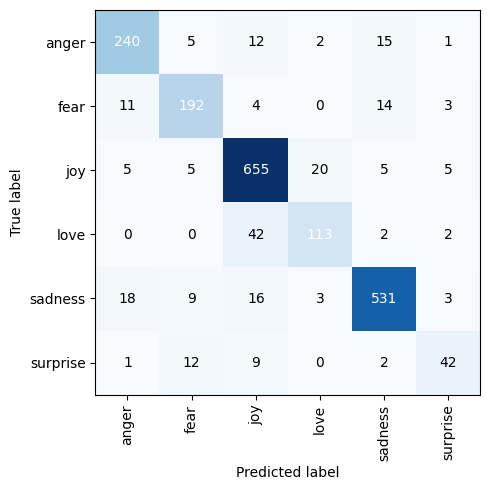

In [25]:
# classify the test data and compute the predicted labels
y_true = test_data["Emotion"].tolist()
y_pred = [svm_classifier.classify(text) for text in test_data["Text"].tolist()]
label_names = svm_classifier.classifier.classes_.tolist() 

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=label_names)
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, cmap='Blues')

# set the tick labels
ax.set_xticks(np.arange(len(label_names)))
ax.set_yticks(np.arange(len(label_names)))
ax.set_xticklabels(label_names, rotation=90)
ax.set_yticklabels(label_names)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

# add annotations to the plot
for i in range(len(label_names)):
    for j in range(len(label_names)):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > len(y_true)/len(label_names)**2 else "black")

plt.show()

In [17]:
label_names

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

### Saving the model with pickle

In [8]:
train_data2 = df_train
svm_classifier2 = SVMClassifier2(train_data2)

# save the trained classifier
with open('svm_classifier.pkl', 'wb') as file:
    pickle.dump(svm_classifier2, file)

**Performing inference with new data (any kind of text data you want)**

In [7]:
# load the trained classifier
with open('svm_classifier.pkl', 'rb') as file:
    svm_classifier = pickle.load(file)

new_data = ["Today I went to the supermarket and bought some fruits, they were delicious!", 
            "I hate this movie", 
            "I was very pleased to see my daughter today",
            "Why are you so angry?",
            "Studying computational linguistics can be hard, but very satisfying!",
            "What are you doing for Christmas? I hope you have a great time"]

# perform inference on new data
y_pred = [svm_classifier.classify(text) for text in new_data]#["Text"].tolist()]

# iterate over the new data and print the predicted emotion for each sentence
for sentence, emotion in zip(new_data, y_pred):
    print(f"'{sentence}' | Predicted emotion: {emotion}")




'Today I went to the supermarket and bought some fruits, they were delicious!' | Predicted emotion: ['joy']
'I hate this movie' | Predicted emotion: ['sadness']
'I was very pleased to see my daughter today' | Predicted emotion: ['joy']
'Why are you so angry?' | Predicted emotion: ['anger']
'Studying computational linguistics can be hard, but very satisfying!' | Predicted emotion: ['sadness']
'What are you doing for Christmas? I hope you have a great time' | Predicted emotion: ['joy']
